In [12]:
import numpy as np
from keras.models import Sequential
from keras.datasets import cifar100
from keras.utils import to_categorical
from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Activation, Input, concatenate, GlobalAveragePooling2D, Dropout
from keras.optimizers import Adam, SGD
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import accuracy_score, precision_score, recall_score
import matplotlib.pyplot as plt

In [13]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [14]:
NUMBER_OF_CLASSES = 100
epochs = 200
batch_size = 100
path_best = "gdrive/My Drive/Colab Notebooks/InceptionV2_ADAM_Dropout.h5"
# path_best = "../weights/InceptionV2_ADAM_Dropout.h5"
path_train = "gdrive/My Drive/Colab Notebooks/InceptionV2_ADAM_Dropout_2.h5" 

In [15]:
(x_train,y_train), (x_test, y_test) = cifar100.load_data()

y_train_norm = to_categorical(y_train, NUMBER_OF_CLASSES)
y_test_norm = to_categorical(y_test, NUMBER_OF_CLASSES)

y_test = y_test.flatten()

x_train = x_train.astype('float32')/255
x_test = x_test.astype('float32')/255

mean = np.mean(x_train, axis=(0,1,2,3))
std = np.std(x_train, axis=(0,1,2,3))

x_train_norm = (x_train-mean)/(std+1e-7)
x_test_norm = (x_test-mean)/(std+1e-7)

In [16]:
datagen = ImageDataGenerator(
    featurewise_center=False,
    samplewise_center=False,
    featurewise_std_normalization=False,
    samplewise_std_normalization=False,
    zca_whitening=False,
    zca_epsilon=1e-06,
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    vertical_flip=False)

datagen.fit(x_train_norm)

In [17]:
def inceptionBuilder(l, f_1x1, f_3x3_r, f_3x3, f_5x5_r, f_5x5, f_p):
    l_1 = Conv2D(filters=f_1x1, kernel_size=(1,1), padding='same', activation='relu')(l)

    l_3 = Conv2D(filters=f_3x3_r, kernel_size=(1,1), padding='same', activation='relu')(l)
    l_3 = Conv2D(filters=f_3x3, kernel_size=(3,3), padding='same', activation='relu')(l_3)
    # l_3 = Dropout(0.5)(l_3)

    l_5 = Conv2D(filters=f_5x5_r, kernel_size=(1,1), padding='same', activation='relu')(l)
    l_5 = Conv2D(filters=f_5x5, kernel_size=(5,5), padding='same', activation='relu')(l_5)
    l_5 = Dropout(0.7)(l_5)

    l_p = MaxPool2D(pool_size=(3,3), strides=(1,1), padding='same')(l)
    l_p = Conv2D(filters=f_p, kernel_size=(1,1), padding='same', activation='relu')(l_p)
    l_p = Dropout(0.5)(l_p)

    ret = concatenate([l_1, l_3, l_5, l_p], axis=3)

    return ret

In [18]:
def create_InceptionV2Model():
    input = Input(shape=(32,32,3))
    l = Conv2D(filters=64, kernel_size=(7,7), padding="same")(input)
    l = Activation('relu')(l)
    
    l = MaxPool2D(pool_size=(3,3), padding='same', strides=(2,2))(l)
    l = Conv2D(filters=64, kernel_size=(1,1), activation='relu')(l)
    l = Conv2D(filters=192, kernel_size=(3,3), activation='relu')(l)
    l = MaxPool2D(pool_size=(3,3), padding='same', strides=(2,2))(l)
    # l = BatchNormalization()(l)

    l = inceptionBuilder(l, 64, 96, 128, 16, 32, 32)
    l = inceptionBuilder(l, 128, 128, 192, 32, 96, 64)

    l = MaxPool2D(pool_size=(3,3,), strides=(2,2), padding='same')(l)

    l = inceptionBuilder(l, 192, 96, 208, 16, 48, 64)
    # l = BatchNormalization()(l)

    l = GlobalAveragePooling2D()(l)
    l = Dense(NUMBER_OF_CLASSES, activation='softmax')(l)

    model = Model(inputs = input, outputs = l)
    return model

In [25]:
model = create_InceptionV2Model()
model.summary()

Model: "functional_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_42 (Conv2D)              (None, 32, 32, 64)   9472        input_3[0][0]                    
__________________________________________________________________________________________________
activation_2 (Activation)       (None, 32, 32, 64)   0           conv2d_42[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_12 (MaxPooling2D) (None, 16, 16, 64)   0           activation_2[0][0]               
_______________________________________________________________________________________

In [26]:
model.compile(optimizer=Adam(learning_rate=0.0001, clipnorm = 1.0), loss=keras.losses.categorical_crossentropy, metrics=['accuracy'])

**Training**

In [27]:
checkpoint = ModelCheckpoint(path_train, monitor='val_accuracy', verbose=1, save_best_only=True, save_weights_only=False, mode='auto',period=1)
early = EarlyStopping(monitor='val_accuracy', min_delta=0, patience=20, verbose=1, mode='auto')

In [28]:
history = model.fit(datagen.flow(x_train_norm, y_train_norm,
                                        batch_size=batch_size),
                        steps_per_epoch=x_train_norm.shape[0]// batch_size,
                        epochs=epochs,
                        validation_data=(x_test_norm,y_test_norm),
                        callbacks=[checkpoint, early],verbose=2)

Epoch 1/200

Epoch 00001: val_accuracy improved from -inf to 0.08720, saving model to gdrive/My Drive/Colab Notebooks/InceptionV2_ADAM_Dropout_2.h5
500/500 - 24s - loss: 4.1795 - accuracy: 0.0614 - val_loss: 4.0466 - val_accuracy: 0.0872
Epoch 2/200

Epoch 00002: val_accuracy improved from 0.08720 to 0.11600, saving model to gdrive/My Drive/Colab Notebooks/InceptionV2_ADAM_Dropout_2.h5
500/500 - 24s - loss: 3.6860 - accuracy: 0.1312 - val_loss: 3.7871 - val_accuracy: 0.1160
Epoch 3/200

Epoch 00003: val_accuracy improved from 0.11600 to 0.14670, saving model to gdrive/My Drive/Colab Notebooks/InceptionV2_ADAM_Dropout_2.h5
500/500 - 24s - loss: 3.4472 - accuracy: 0.1714 - val_loss: 3.6046 - val_accuracy: 0.1467
Epoch 4/200

Epoch 00004: val_accuracy improved from 0.14670 to 0.16710, saving model to gdrive/My Drive/Colab Notebooks/InceptionV2_ADAM_Dropout_2.h5
500/500 - 24s - loss: 3.2726 - accuracy: 0.2026 - val_loss: 3.5026 - val_accuracy: 0.1671
Epoch 5/200

Epoch 00005: val_accuracy 

*Plotting training accuracy and loss*

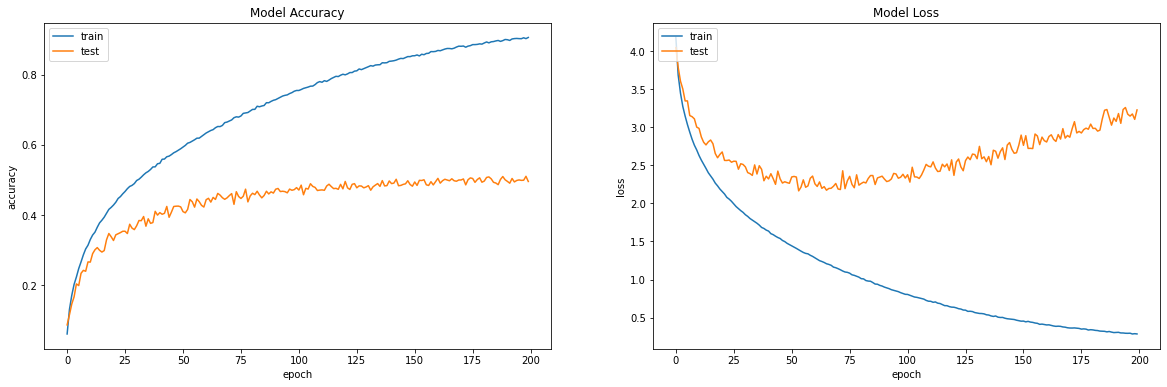

In [29]:
fig, axs = plt.subplots(1, 2, figsize=(20, 6))
axs[0].plot(history.history['accuracy'])
axs[0].plot(history.history['val_accuracy'])
axs[0].set_title('Model Accuracy')
axs[0].set(ylabel ='accuracy')
axs[0].set(xlabel ='epoch')
axs[0].legend(['train', 'test'], loc='upper left')

axs[1].plot(history.history['loss'])
axs[1].plot(history.history['val_loss'])
axs[1].set_title('Model Loss')
axs[1].set(ylabel='loss')
axs[1].set(xlabel='epoch')
axs[1].legend(['train', 'test'], loc='upper left')

**Prediction**

In [34]:
model.load_weights(path_best)
y_pred = np.argmax(model.predict(x_test_norm), axis=-1)

In [35]:
precision = precision_score(y_test, y_pred, average='weighted')
print("Precision: ", precision)
recall = recall_score(y_test, y_pred, average='weighted')
print("Recall: ", recall)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: ", accuracy)

Precision:  0.5531250178890929
Recall:  0.5234
Accuracy:  0.5234
